## Анализируем лица с помощью искусственного интеллекта

Материалы воркшопа с зимней школы **Искусственный интеллект в психологии 2020**.

В современной науке всё большее значение принимают методы, основанные на машинном обучении и анализе данных. Мы попробуем использовать анализ данных для того, чтобы сделать некоторые (исключительно грубые) выводы о человеческой психологии на основа анализа изображений.

В нашем случае мы будем использовать небольшое количество изображений, для ускорения процесса обработки. Поэтому выводы, которые мы сможем сделать, не будут статистически обоснованы. Однако в случае, если в нашем распоряжении окажется большее количество фотографий, мы сможем попробовать получить более достоверные результаты с помощью такой же методики.

### Когнитивные сервисы для анализа изображений

Большое количество контента в интернет/соц.сетях - это изображения. Мы можем использовать нейросетевые модели для извлечения из изображений глубинной информации о содержимом, например:
 * Для каждого из людей на фото - пол, возраст, испытываемые эмоции, наличие аксессуаров на лице
 * Список объектов на фотографии
 * Контекст: в помещении, на улице
 * Тип фото: портрет, групповое фото, пейзаж
 * Цветовая гамма
 
В нашем случае мы сконцентрируемся на извлечении информации о людях. Для этого будем использовать облачный сервис [Microsoft Azure Face API](https://docs.microsoft.com/azure/cognitive-services/face/overview/?wt.mc_id=psycho-events-dmitryso).

Для использования Face API нам необходим специальный ключ, а также интернет-адрес для вызова сервиса (Endpoint URL). Есть несколько способов получить ключ:

* Если у Вас есть подписка Microsoft Azure, [создайте ресурс Face API](https://docs.microsoft.com/azure/cognitive-services/cognitive-services-apis-create-account/?wt.mc_id=crpyface-github-dmitryso), и скопируйте ключ и URL оттуда.
* Вы всегда можете [создать бесплатную пробную подписку](https://azure.microsoft.com/free/?wt.mc_id=psycho-events-dmitryso), по которой в течение месяца вы сможете расходовать определенный предоставленный вам кредитный лимит, а затем в течение года получать ограниченный набор сервисов бесплатно (для этого понадобится кредитная карта).
* Студенты могут завести облачный аккаунт [здесь](http://aka.ms/az4stud), верифицировав свой студенческий статус с помощью e-mail в домене университета. Альтернативно, сразу много бесплатных студенческих ресурсов можно получить через [GitHub Student Developer Pack](https://education.github.com/pack) - он поддерживает верификацию по документу, но она требует чуть больше времени. 

**Важно:** При использовании бесплатной категории Face API, будут некоторые ограничения по количеству изображений, которые вы сможете обработать (несколько тысяч), а также по частоте запросов (не более 20 запросов в минуту). Для обеспечения работы без ошибок, возможно, придется вставлять паузы между запросами к сервису.

Полученный ключ и адрес Endpoint URL введите в ячейке ниже:

In [3]:
key = '--INSERT YOUR KEY HERE--'
endpoint = 'https://westus2.api.cognitive.microsoft.com' 
# You might need different endpoint, check the cognitive services page!

Для работы с Face API нам нужно установить специальную библиотеку, а также убедиться, что другие важные библиотеки Python установлены:

In [4]:
import sys
!{sys.executable} -m pip install --quiet --user matplotlib pandas ipyplot
!{sys.executable} -m pip install --quiet --user azure-cognitiveservices-vision-face
import os, matplotlib.pyplot as plt, json, pickle

Все вызовы к Face API производятся с помощью модуля `cognitive_face`, который мы для краткости назовём `cf`:

In [5]:
import azure.cognitiveservices.vision.face as cf
from msrest.authentication import CognitiveServicesCredentials
cli = cf.FaceClient(endpoint,CognitiveServicesCredentials(key))

Основные функции для обработки лица -- `face.detect_with_url` и `face.detect_with_stream`. Они извлекают из лица разную информацию в зависимости от передаваемых параметров. Например. попробуем проанализировать следующее изображение:
![](https://2016.dotnext-piter.ru/assets/images/people/soshnikov.jpg)

In [4]:
res = cli.face.detect_with_url('https://2016.dotnext-piter.ru/assets/images/people/soshnikov.jpg',
                               return_face_attributes=['emotion','age','gender'], return_face_id=False)
print(res[0].as_dict())

{'face_rectangle': {'width': 127, 'height': 127, 'left': 83, 'top': 87}, 'face_attributes': {'age': 39.0, 'gender': 'male', 'emotion': {'anger': 0.0, 'contempt': 0.0, 'disgust': 0.0, 'fear': 0.0, 'happiness': 1.0, 'neutral': 0.0, 'sadness': 0.0, 'surprise': 0.0}}}


### Анализируем фотографии с летней школы

Проанализируем фотографии с летней школы ИИ, расположенные в интернет [вот тут](http://psy.msu.ru/science/conference/summer/2019/photo/index.html).
Можно заметить, что все фотографии имеют адрес http://psy.msu.ru/science/conference/summer/2019/photo/xxx.jpg, где xxx - номер фото, от 000 до 131.

In [9]:
urls = ["http://psy.msu.ru/science/conference/summer/2019/photo/{:03d}.jpg".format(i) for i in range(1,131)]

In [6]:
import pandas as pd

In [7]:
import ipyplot

In [16]:
ipyplot.plot_images(urls[::10],img_width=150)

In [18]:
data = []
for x in urls:
    print("Analyzing {} ...".format(x),end='')
    res = cli.face.detect_with_url(x, return_face_attributes=['emotion','age','gender'], return_face_id=False)
    nfaces = len(res)
    print(nfaces, ' faces')
    for t in res:
        fa = t.as_dict()['face_attributes']
        em = fa['emotion']
        z = { 'gender' : fa['gender'], 'age' : fa['age'], 'nfaces' : nfaces }
        data.append(dict(list(z.items())+list(em.items())))
print("Found {} faces".format(len(data)))

with open('data.json','w') as f:
    json.dump(data,f)

Analyzing http://psy.msu.ru/science/conference/summer/2019/photo/001.jpg ...1  faces
Analyzing http://psy.msu.ru/science/conference/summer/2019/photo/002.jpg ...1  faces
Analyzing http://psy.msu.ru/science/conference/summer/2019/photo/003.jpg ...0  faces
Analyzing http://psy.msu.ru/science/conference/summer/2019/photo/004.jpg ...0  faces
Analyzing http://psy.msu.ru/science/conference/summer/2019/photo/005.jpg ...0  faces
Analyzing http://psy.msu.ru/science/conference/summer/2019/photo/006.jpg ...0  faces
Analyzing http://psy.msu.ru/science/conference/summer/2019/photo/007.jpg ...3  faces
Analyzing http://psy.msu.ru/science/conference/summer/2019/photo/008.jpg ...3  faces
Analyzing http://psy.msu.ru/science/conference/summer/2019/photo/009.jpg ...1  faces
Analyzing http://psy.msu.ru/science/conference/summer/2019/photo/010.jpg ...3  faces
Analyzing http://psy.msu.ru/science/conference/summer/2019/photo/011.jpg ...4  faces
Analyzing http://psy.msu.ru/science/conference/summer/2019/photo/

In [19]:
df = pd.DataFrame(data)
df

gender   age  nfaces  anger  contempt  disgust  fear  happiness  neutral  \
0    female  24.0       1    0.0     0.000      0.0   0.0      0.991    0.009   
1    female  23.0       1    0.0     0.000      0.0   0.0      1.000    0.000   
2    female  23.0       3    0.0     0.000      0.0   0.0      1.000    0.000   
3    female  24.0       3    0.0     0.000      0.0   0.0      1.000    0.000   
4    female  25.0       3    0.0     0.000      0.0   0.0      1.000    0.000   
..      ...   ...     ...    ...       ...      ...   ...        ...      ...   
328  female  19.0       9    0.0     0.000      0.0   0.0      1.000    0.000   
329  female  28.0       9    0.0     0.000      0.0   0.0      0.904    0.096   
330  female  22.0       9    0.0     0.001      0.0   0.0      0.350    0.647   
331  female  18.0       9    0.0     0.000      0.0   0.0      0.864    0.136   
332  female  28.0       9    0.0     0.000      0.0   0.0      1.000    0.000   

     sadness  surprise  
0      0.000       0.0  
1      0.000       0.0  
2      0.000       0.0  
3      0.000       0.0  
4      0.000       0.0  
..       ...       ...  
328    0.000       0.0  
329    0.000       0.0  
330    0.001       0.0  
331    0.000       0.0  
332    0.000       0.0  

[333 rows x 11 columns]

Мы загрузили все данные в `DataFrame` по имени `df`, и дальше попробуем его проанализировать. Ниже, когда мы загрузим данные из другого источника, мы сможем перейти снова к этой ячейке и построить графики, просто выполняя ячейки одну за другой.

Можем сохранить данные на диск, что впоследствии можно было для демонстрации их быстро загрузить

In [56]:
df.to_pickle('data_conf.pkl')

In [58]:
df = pd.read_pickle('data_conf.pkl')

## Смотрим на результаты графически

Посмотрим на распределение возрастов на конференции:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024FBB72D7C8>]],
      dtype=object)

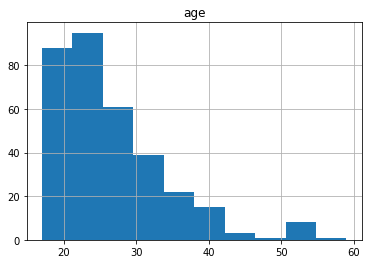

In [24]:
df.hist('age')

А как распределен уровень счастья?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000024FBB183148>]],
      dtype=object)

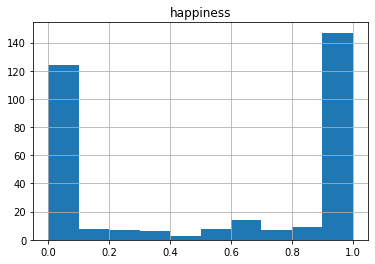

In [25]:
df.hist('happiness')

Можем также построить зависимость счастья от возраста:

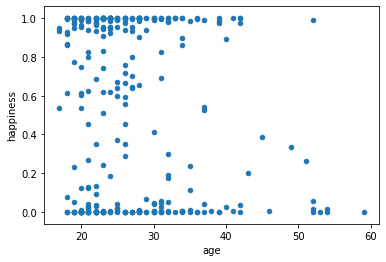

In [29]:
df.plot.scatter('age','happiness')

Посмотрим на распределение счастья в зависимости от пола:

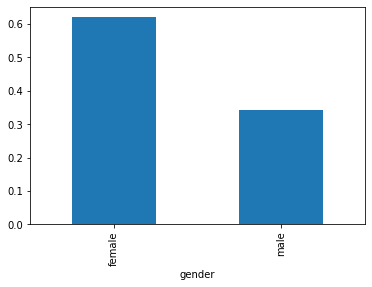

In [34]:
df.groupby('gender').mean()['happiness'].plot.bar()

**Вывод:** девушки более счастливы!

И в зависимости от количества лиц на фотографии:

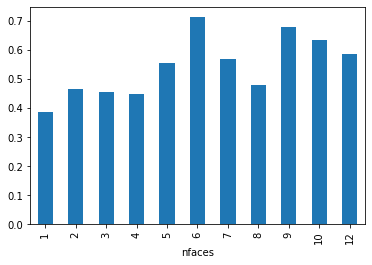

In [35]:
df.groupby('nfaces').mean()['happiness'].plot.bar()

**Вывод:** фотографироваться в компании немного веселее, но не сильно.

Наконец, распределение среднего счасться по возрастным группам:

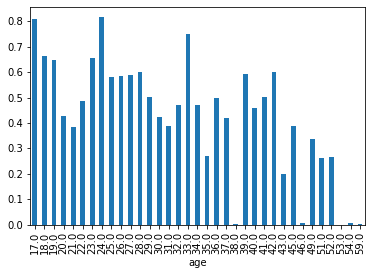

In [36]:
df.groupby('age').mean()['happiness'].plot.bar()

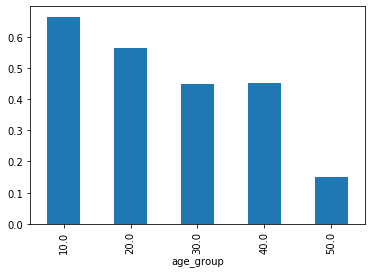

In [37]:
df['age_group'] = (df['age'] // 10)*10
df.groupby('age_group').mean()['happiness'].plot.bar()

Если счастье убывает, то интересно посмотреть, какие эмоции возрастают. Например, аналогичная динамика для грусти:

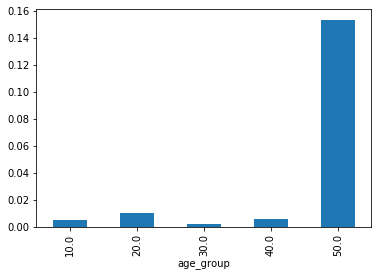

In [38]:
df.groupby('age_group').mean()['sadness'].plot.bar()

Посмотрим на средние эмоции людей:

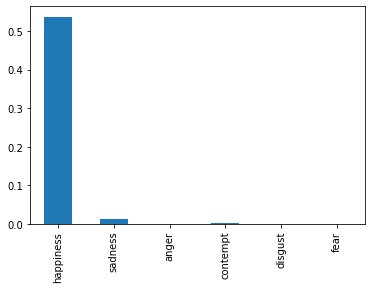

In [45]:
df.mean()[['happiness','sadness','anger','contempt','disgust','fear']].plot.bar()

Тоже самое по мужчинам и по женщинам:

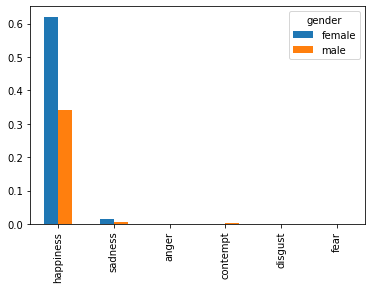

In [52]:
df.groupby('gender').mean()[['happiness','sadness','anger','contempt','disgust','fear']].T.plot.bar()

### Анализируем свои фотографии

Разместим коллекцию фотографий в директории `images`. Самый простой способ сделать это - загрузить фотографии вручную через интерфейс Azure Notebooks. Для примера я загружу заранее заготовленные фото:

In [ ]:
!wget http://www.soshnikov.com/temp/psyimages.zip
!unzip psyimages.zip
!rm psyimages.zip

In [17]:
import PIL, glob, numpy as np

data = []
for fn in glob.glob("images/*"):
    print("Processing {}".format(fn),end=' ')
    with open(fn,'rb') as f:
        res = cli.face.detect_with_stream(f,return_face_landmarks=False,return_face_id=False,return_face_attributes=['emotion','age','gender'])
    nfaces = len(res)
    print(nfaces,' faces')
    im = PIL.Image.open(fn)
    img = np.array(im)
    for t in res:
        fa = t.as_dict()['face_attributes']
        em = fa['emotion']
        fr = t.as_dict()['face_rectangle']
        face = img[fr['top']:fr['top']+fr['height'],fr['left']:fr['left']+fr['width'],:]
        z = { 'gender' : fa['gender'], 'age' : fa['age'], 'nfaces' : nfaces, 'face' : face, 'img' : img  }
        data.append(dict(list(z.items())+list(em.items())))

print("Found {} faces".format(len(data)))


Processing images\IMG_0306.jpg 1  faces
Processing images\IMG_0521.jpg 3  faces
Processing images\IMG_0600.jpg 1  faces
Processing images\IMG_0781.jpg 3  faces
Processing images\IMG_0809.jpg 4  faces
Processing images\IMG_0872.jpg 4  faces
Processing images\IMG_0908.jpg 13  faces
Processing images\IMG_0923.jpg 7  faces
Processing images\IMG_0985.jpg 1  faces
Processing images\IMG_1018.jpg 5  faces
Processing images\IMG_1199.jpg 2  faces
Processing images\IMG_1241.jpg 2  faces
Processing images\IMG_1256.jpg 6  faces
Found 52 faces


In [26]:
df_full = pd.DataFrame(data)
df = df_full.drop(['img','face'],1)
df.to_pickle('data_faces.pkl')

Мы снова загрузили данные в список `data`, поэтому мы можем перейти вверх к ячейке **Смотрим на результаты графически** и выполнить ячейки, изучая результаты и делая выводы.

Поскольку в этом случае у нас также есть сами изображения, попробуем найти самые ярко-выраженные эмоции на фотографиях:

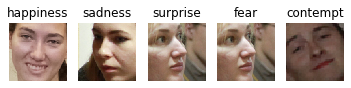

In [28]:
emotions = ['happiness','sadness','surprise','fear','contempt']
emos = { t:(0,None) for t in emotions}
for x in data:
    for k,v in emos.items():
        if x[k]>=v[0]:
            emos[k]=(x[k],x['face'])
fix,ax = plt.subplots(1,len(emos.keys()))
for i,e in enumerate(emos.keys()):
    if emos[e][1] is not None:
        ax[i].imshow(emos[e][1])
        ax[i].axis('off')
        ax[i].set_title(e)
plt.show()

Теперь найдём наиболее "противоречивую" эмоцию, в которой две составляющих проявлены наиболее сильно. Для этого ищем лицо, в котором максимально значение второй по величине эмоции, не считая нейтральной:

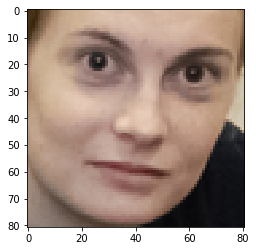

{'happiness': 0.087,
 'sadness': 0.0,
 'surprise': 0.057,
 'fear': 0.0,
 'contempt': 0.0}

In [33]:
mx = 0
img = None
emo = None
for x in data:
    em = { k: x[k] for k in emotions }
    snd = sorted(em.values())[-2]
    if snd>mx:
        mx = snd
        img = x['face']
        emo = em
plt.imshow(img)
plt.show()
emo

## Дальнейшая обработка результатов методами Data Science

Полученные результаты могут использоваться для дальнейших исследований с помощью алгоритмов машинного обучения. Например, мы увидели выше интресное сочетание эмоций. Можем посмотреть, выделяются ли среди всех лиц некоторые "типичные" конфигурации. Для этого необходимо применить алгоритм кластеризации, который реализован в библиотеке *Scikit Learn*:

In [34]:
import sklearn.cluster
inp = np.array([ [ x[e] for e in emotions ] for x in data])
centroid, labels, inertia = sklearn.cluster.k_means(inp,3)

Мы попросили разбить все лица на 3 кластера, на основе расстояний между векторами эмоций. Теперь посмотрим на то, какие конфигурации эмоций у нас получились в центре таких кластеров (они возвращены в переменной `centroids`), и на наиболее "характерные" (близкие по расстоянию) лица для каждого из кластеров

In [35]:
def closest_face(e):
    mi = 999
    el = None
    for i,x in enumerate(data):
        if np.linalg.norm(inp[i]-e)<mi:
            mi=np.linalg.norm(inp[i]-e)
            el=x
    return el['face']

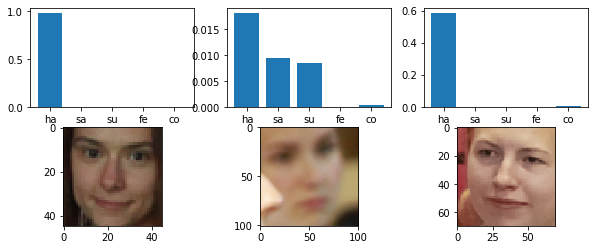

In [37]:
fig,ax = plt.subplots(2,len(centroid),figsize=(10,4))
for i,x in enumerate(centroid):
    ax[0,i].bar([t[0:2] for t in emotions],x)
    ax[1,i].imshow(closest_face(x))
plt.show()

Посмотрим на все лица в интересном кластере 0:

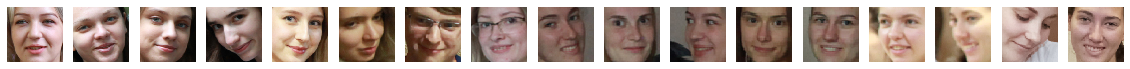

In [38]:
res = [x['face'] for x,i in zip(data,labels) if i==0]
fig,ax = plt.subplots(1,len(res),figsize=(20,4))
for i,x in enumerate(res):
    ax[i].imshow(x)
    ax[i].axis('off')
plt.show()

## Экспериментируйте!

Не забывайте, что вы можете всегда загрузить новые фотографии в директорию `images`, и повторить данный эксперимент для новых данных. Более того, вы можете использовать этот ноутбук как заготовку для дальнейших исследований и экспериментов! Если у вас будет получаться что-то интересное --- делитесь результатами!

Контакты:
* Дмитрий Сошников
* Cloud Developer Advocate, Microsoft
* Доцент, МФТИ/НИУ ВШЭ/МАИ
* http://soshnikov.com
* http://t.me/shwars

In [1]:
!rm images/*